In [1]:
import requests

# Define the URL
url = "http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Electronics.json.gz"
filename = "reviews_Electronics.json.gz"

# Download the file
response = requests.get(url, stream=True)
with open(filename, "wb") as file:
    for chunk in response.iter_content(chunk_size=1024):
        file.write(chunk)

print(f"Dataset downloaded as {filename}")

Dataset downloaded as reviews_Electronics.json.gz


In [3]:
import pandas as pd
import gzip
import json

# Define the file path
file_path = "reviews_Electronics.json.gz"

# Read the gzip file
def load_data(file_path, num_records=100000):  # Load a subset for efficiency
    data = []
    with gzip.open(file_path, 'rt', encoding="utf-8") as f:
        for i, line in enumerate(f):
            if i >= num_records:
                break
            data.append(json.loads(line))
    return pd.DataFrame(data)

# Load a subset of data
df = load_data(file_path, num_records=50000)

# Display first few rows
print(df.head())

       reviewerID        asin          reviewerName helpful  \
0   AKM1MP6P0OYPR  0132793040  Vicki Gibson "momo4"  [1, 1]   
1  A2CX7LUOHB2NDG  0321732944                Bernie  [0, 0]   
2  A2NWSAGRHCP8N5  0439886341           bowmans2007  [1, 1]   
3  A2WNBOD3WNDNKT  0439886341                   JAL  [1, 1]   
4  A1GI0U4ZRJA8WN  0439886341             Truthfull  [4, 4]   

                                          reviewText  overall  \
0  Corey Barker does a great job of explaining Bl...      5.0   
1  While many beginner DVDs try to teach you ever...      5.0   
2  It never worked. My daughter worked to earn th...      1.0   
3  Some of the functions did not work properly.  ...      3.0   
4  Do not waste your money on this thing it is te...      1.0   

                                             summary  unixReviewTime  \
0                                      Very thorough      1365811200   
1  Adobe Photoshop CS5 Crash Course with master P...      1341100800   
2             

In [5]:
# Keep only necessary columns
df = df[['reviewText', 'overall']]

# Drop missing values
df.dropna(inplace=True)

# Display dataset info
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   reviewText  50000 non-null  object 
 1   overall     50000 non-null  float64
dtypes: float64(1), object(1)
memory usage: 781.4+ KB
None


In [7]:
# Define sentiment classification
def get_sentiment(rating):
    if rating <= 2:
        return "Negative"
    elif rating == 3:
        return "Neutral"
    else:
        return "Positive"

# Apply the function
df['sentiment'] = df['overall'].apply(get_sentiment)

# Show distribution
print(df['sentiment'].value_counts())

sentiment
Positive    37821
Negative     8252
Neutral      3927
Name: count, dtype: int64


In [9]:
import re
import nltk
from nltk.corpus import stopwords

# Download stopwords if not already downloaded
nltk.download('stopwords')

# Preprocessing function
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^a-z\s]', '', text)  # Remove special characters
    words = text.split()
    words = [word for word in words if word not in stopwords.words('english')]  # Remove stopwords
    return " ".join(words)

# Apply cleaning
df['cleaned_review'] = df['reviewText'].apply(clean_text)

print(df.head())

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\suvee\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                          reviewText  overall sentiment  \
0  Corey Barker does a great job of explaining Bl...      5.0  Positive   
1  While many beginner DVDs try to teach you ever...      5.0  Positive   
2  It never worked. My daughter worked to earn th...      1.0  Negative   
3  Some of the functions did not work properly.  ...      3.0   Neutral   
4  Do not waste your money on this thing it is te...      1.0  Negative   

                                      cleaned_review  
0  corey barker great job explaining blend modes ...  
1  many beginner dvds try teach everything know p...  
2  never worked daughter worked earn money get ne...  
3  functions work properly daughter bought money ...  
4  waste money thing terrible boutght product son...  


In [13]:
pip install wordcloud

   ---------------------------------------- 0.0/301.2 kB ? eta -:--:--
   ---- ----------------------------------- 30.7/301.2 kB ? eta -:--:--
   -------- ------------------------------- 61.4/301.2 kB 1.1 MB/s eta 0:00:01
   ---------------- ----------------------- 122.9/301.2 kB 1.2 MB/s eta 0:00:01
   ------------------------ --------------- 184.3/301.2 kB 1.2 MB/s eta 0:00:01
   ------------------------------- -------- 235.5/301.2 kB 1.2 MB/s eta 0:00:01
   ---------------------------------------- 301.2/301.2 kB 1.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


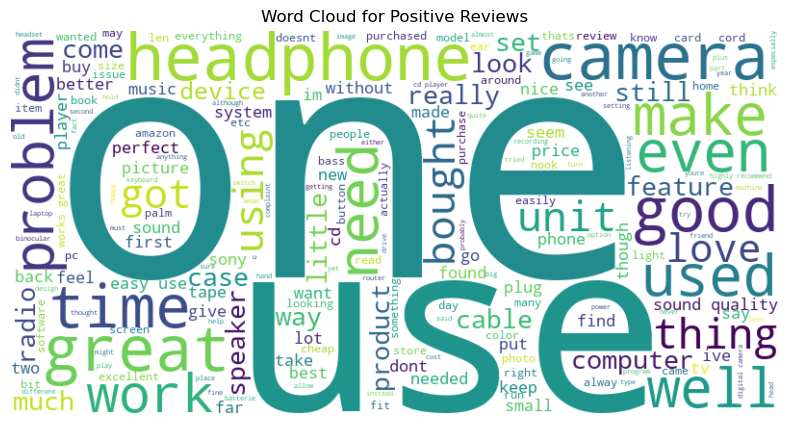

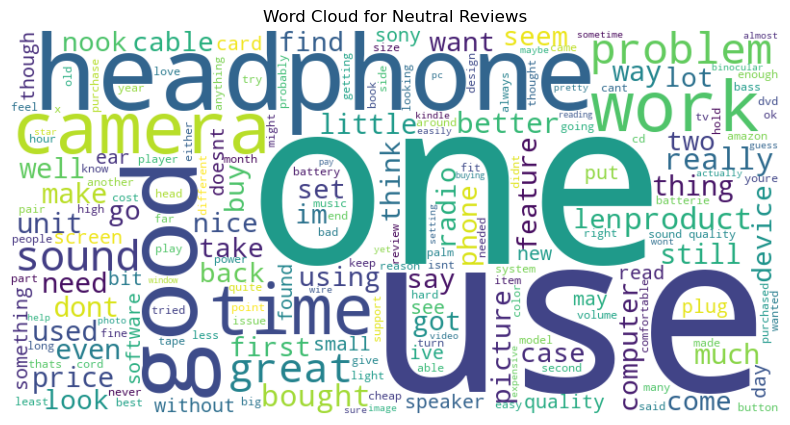

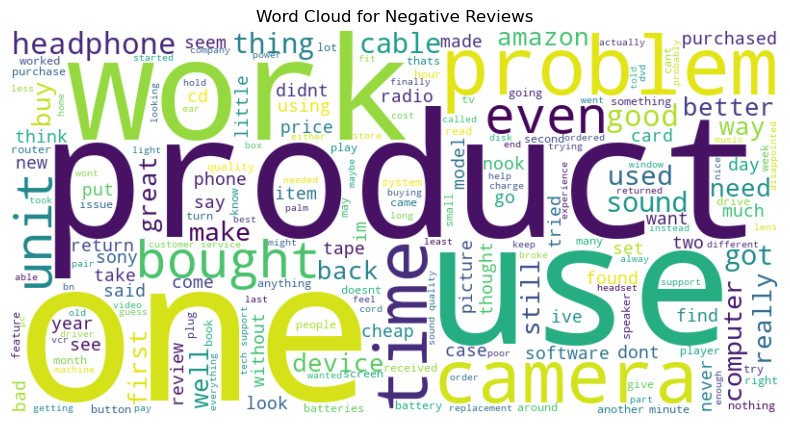

In [15]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Function to create a word cloud
def generate_wordcloud(sentiment):
    text = " ".join(df[df['sentiment'] == sentiment]['cleaned_review'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud for {sentiment} Reviews")
    plt.show()

# Generate word clouds for each sentiment category
for sentiment in ["Positive", "Neutral", "Negative"]:
    generate_wordcloud(sentiment)

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report

# Split data
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_review'], df['sentiment'], test_size=0.2, random_state=42)

# Create a pipeline with TF-IDF and Naive Bayes
model = Pipeline([
    ('vectorizer', CountVectorizer()),  # Convert text to count vectors
    ('tfidf', TfidfTransformer()),  # Apply TF-IDF transformation
    ('classifier', MultinomialNB())  # Train a Naive Bayes classifier
])

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.7612
              precision    recall  f1-score   support

    Negative       1.00      0.00      0.00      1633
     Neutral       0.00      0.00      0.00       759
    Positive       0.76      1.00      0.86      7608

    accuracy                           0.76     10000
   macro avg       0.59      0.33      0.29     10000
weighted avg       0.74      0.76      0.66     10000



C:\Users\suvee\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\suvee\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\suvee\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [19]:
def predict_sentiment(review):
    cleaned_review = clean_text(review)
    prediction = model.predict([cleaned_review])
    return prediction[0]

# Example reviews
new_reviews = [
    "This product is amazing! Works perfectly.",
    "Terrible quality. Stopped working in a week.",
    "It's okay, but nothing special."
]

for review in new_reviews:
    print(f"Review: {review} -> Sentiment: {predict_sentiment(review)}")

Review: This product is amazing! Works perfectly. -> Sentiment: Positive
Review: Terrible quality. Stopped working in a week. -> Sentiment: Positive
Review: It's okay, but nothing special. -> Sentiment: Positive


#

In [22]:
# Define additional stopwords (domain-specific)
custom_stopwords = set([
    "amazon", "product", "buy", "purchase", "order", "shipping", 
    "item", "seller", "price", "review", "star", "stars", "company",
    "package", "service", "delivered", "received", "return", "refund",
    "bought", "purchase", "recommend", "brand"
])

# Update NLTK stopwords
nltk.download('stopwords')
all_stopwords = set(stopwords.words('english')).union(custom_stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\suvee\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^a-z\s]', '', text)  # Remove special characters
    words = text.split()
    words = [word for word in words if word not in all_stopwords]  # Remove all stopwords
    return " ".join(words)

# Apply cleaning function again
df['cleaned_review'] = df['reviewText'].apply(clean_text)

print("Sample cleaned text:\n", df['cleaned_review'].head())

Sample cleaned text:
 0    corey barker great job explaining blend modes ...
1    many beginner dvds try teach everything know p...
2    never worked daughter worked earn money get ne...
3    functions work properly daughter money disappo...
4    waste money thing terrible boutght son put pho...
Name: cleaned_review, dtype: object


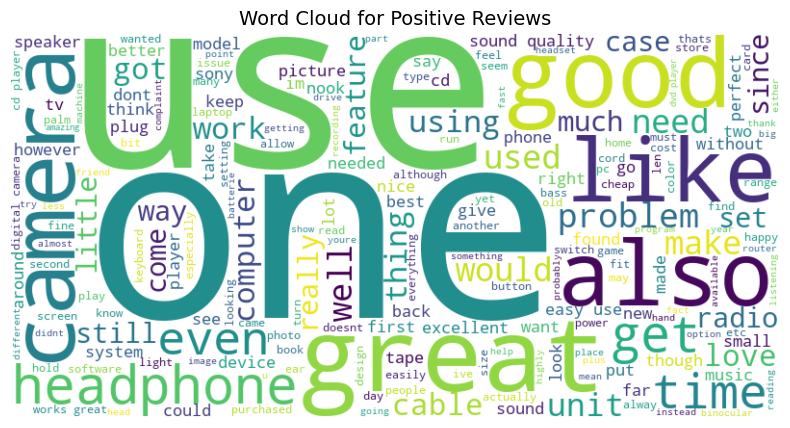

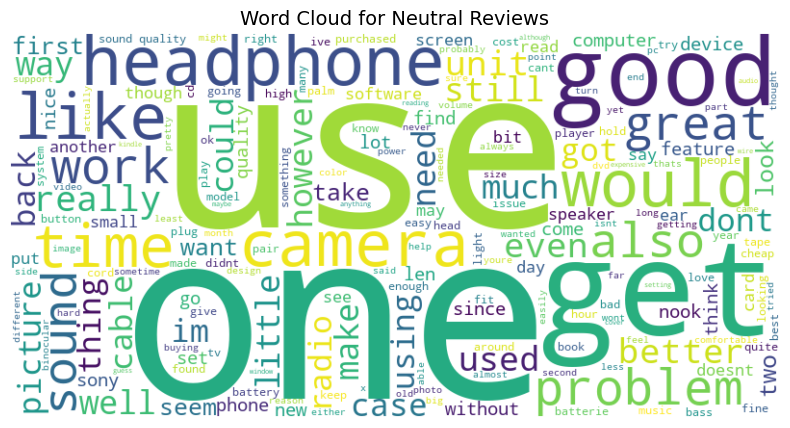

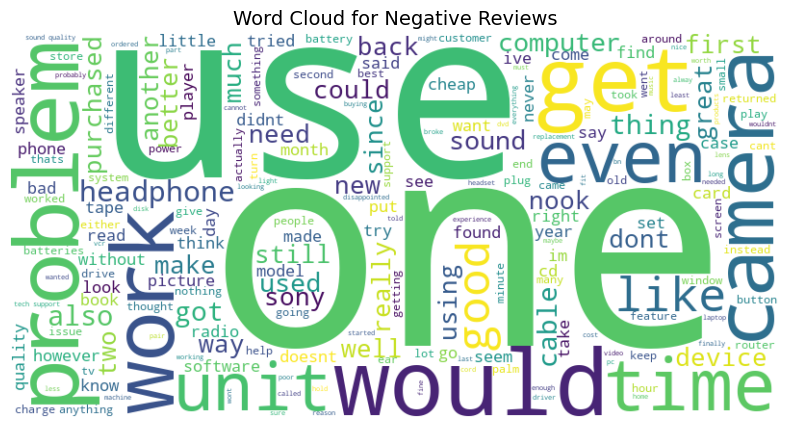

In [26]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Function to create a word cloud
def generate_wordcloud(sentiment):
    text = " ".join(df[df['sentiment'] == sentiment]['cleaned_review'])
    wordcloud = WordCloud(
        width=800, height=400, background_color='white', 
        stopwords=all_stopwords, colormap='viridis'
    ).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud for {sentiment} Reviews", fontsize=14)
    plt.show()

# Generate word clouds for each sentiment category
for sentiment in ["Positive", "Neutral", "Negative"]:
    generate_wordcloud(sentiment)